# Códigos para Plotar Série Histórica de Emissões
## Plotando Jan-d01 
## Opções EDGAR 

Carregar saídas SMOKE para demonstrar perfis de emissões, considerando domínio

In [1]:
import pandas as pd
from netCDF4 import Dataset
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.basemap import Basemap
from matplotlib.collections import PatchCollection
from matplotlib.patches import Polygon
import seaborn as sns
import datetime as dt
%matplotlib inline

## *Entradas*
* Selecionar arquivos de origem para preparar figuras.
* Inicializar variáveis para figuras.

### Parametrização dos arquivos de entrada

Ajustar diretório que contem os arquivos, nomes de rodadas, e shapefiles a serem plotados

In [28]:
directory = str('D:/Mestrado/1.Resultados/Emissoes/')
wrfdir = str('D:/Mestrado/1.Resultados/Meteorologia/')
mes   = ['jan','jul']
grade = 'd04_1km'
data  = ['20150109','20150724']
datawrf  = ['01-09','07-24']
moded = ['COMBO', 'COMBO-20I', 'COMBO-20T', 'COMBO-20I-20T']
modedname = ['ED', 'ED-20I', 'ED-20T', 'ED-20I-20T']
modpt = ['PT_ED-100I', 'PT_ED-100I-20T', 'PT-20_ED-100I', 'PT-20_ED-100I-20T']
shapes = ['pirashape','RMSP']
spinup = 48
run_len = 24*7
gmt = 3
mes_index = 0


## Abrir arquivos SMOKE

In [29]:
mods = []
for i in range(0,len(modpt)):
    mods.append(xr.open_dataset(directory+'pt.'+mes[mes_index]+'.'+grade+
                                '/egts_l.'+data[mes_index]+'.9.'+
                                grade[:3]+'.htapv2.'+modpt[i]+'.ncf'))
    mods[i] = mods[i].isel(LAY=0)
for mod in moded:
    mods.append(xr.open_dataset(directory+mes[mes_index]+'.'+grade+
                                '/agts_l.edgar.'+data[mes_index]+'.9.'+
                                grade[:3]+'.htapv2.'+mod+'.ncf'))

## Abrir arquivo WRF para buscar valores de LAT / LON

In [30]:
nc_wrf = Dataset(wrfdir+'arqWRF/'+mes[mes_index]+'/wrf_fnl_pira_pedruzzi2016_nudge_'+
                 mes[mes_index]+'/wrfout_'+grade[:3]+'_2015-'+datawrf[mes_index]+'_00%3A00%3A00')

## Preparar coordenadas para XArray
* DATAS
* ALTITUDE
* LATITUDE
* LONGITUDE

In [31]:
for m in mods:
    
# DATAS
    dates = [dt.datetime.strptime(str(m.attrs['SDATE']),'%Y%j')]
    for i in range(1,m.dims['TSTEP']):
        dates.append(dates[0]+dt.timedelta(hours=i))

# LATITUDE
# LONGITUDE
    croplat = int((nc_wrf.dimensions['south_north'].size-m.dims['ROW'])/2)
    croplon = int((nc_wrf.dimensions['south_north'].size-m.dims['ROW'])/2)
    lats      = nc_wrf.variables['XLAT'][0,croplat:-croplat,croplat:-croplat]
    longs     = nc_wrf.variables['XLONG'][0,croplon:-croplon,croplon:-croplon]

# PLOT CORNERS
    llcrnrlon = np.min(longs)      #longitude of lower left hand corner of the selected map domain.
    llcrnrlat = np.min(lats)       #latitude of upper right hand corner of the desired map domain (degrees).
    urcrnrlon = np.max(longs)      #longitude of upper right hand corner of the selected map domain.
    urcrnrlat = np.max(lats)      #latitude of upper right hand corner of the selected map domain.

    coordlat  = np.linspace(llcrnrlat,urcrnrlat,num=m.dims['ROW'])
    coordlon  = np.linspace(llcrnrlon,urcrnrlon,num=m.dims['COL'])


# ADJUSTMENTS
    m.coords['TSTEP'] = dates
    m.coords['ROW'] = coordlat
    m.coords['COL'] = coordlon
    m.rename({'ROW': 'LAT', 'COL': 'LON'}, inplace=True)
    for var in m.variables:
        if 'units' in m.variables[var].attrs:
            m.variables[var].attrs['units'] = m.variables[var].attrs['units'].split()[0]


## Ajuste de tempo
* Crop de datas
* Ajuste para horário local
* Cria nomenclatura weekd

In [32]:
for i in range(0,len(mods)):
    # slice spinup e tamanho da rodada
    mods[i] = mods[i].isel(TSTEP=slice(spinup,spinup+run_len))
    # ajuste para horário local
    mods[i].coords['TSTEP'] -= pd.Timedelta(gmt,'h')
# Cria variaveis de weekend
weekd=[]
for d in mods[0].TSTEP.dt.weekday:
    if d < 5:
        weekd.append('Dias da Semana')
    else:
        weekd.append('Fim de Semana')

## Preparar variáveis agregadas de emissões 
O objetivo é comparar com o inventário de emissões da CETESB  
https://cetesb.sp.gov.br/ar/wp-content/uploads/sites/28/2013/12/RQAR-2015.pdf

* **CO  --> Variables ['CO']**
* **HC  --> VOC --> Variable ['VOC']**  
    *ALD2, ALDX, BENZENE, ETH, ETHA, ETOH, FORM, IOLE, ISOP, MEOH, NAPH, NVOL, OLE, PAR, SOAALK, TERP, TOL, UNR, XYLMN*
* **NOx --> Variable['NOx']**  
    *HONO, NO, NO2*
* **MP  --> Variable['MP']**  
    *PAL, PCA, PCL, PFE, PH2O, PK, PMG, PMN, PMOTHR, PNA, PNCOM, PNH4, PNO3, PSI, PSO4, PTI, PMC, PEC, POC, PMFINE*
* **SOx --> Variable['SOx']**  
    *SO2, SULF*

In [33]:
VOCvar = ['ALD2' , 'ALDX', 'BENZENE', 'ETH'   , 'ETHA'  , 
          'ETOH' , 'FORM', 'IOLE'   , 'ISOP'  , 'MEOH'  , 
          'NAPH' , 'NVOL', 'OLE'    , 'PAR'   , 'SOAALK', 
          'TERP' , 'TOL' , 'UNR'    , 'XYLMN']
NOxvar = ['HONO' , 'NO'  , 'NO2']
MPvar  = ['PAL'  , 'PCA' , 'PCL'    , 'PFE'   , 'PH2O'  , 
          'PK'   , 'PMG' , 'PMN'    , 'PMOTHR', 'PNA'   ,
          'PNCOM', 'PNH4', 'PNO3'   , 'PSI'   , 'PSO4'  , 
          'PTI'  , 'PMC' , 'PEC'    , 'POC'   , 'PMFINE']
SOxvar = ['SO2'  , 'SULF']

cVOC = []
cNOx = []
cMP  = []
cSOx = []
for m in range(0, len(mods)):
# VOC
    #Inicializar
    
    cVOC.append(mods[m].variables[VOCvar[0]]+mods[m].variables[VOCvar[1]])
    #Unir todas as variáveis
    for i in range(2,len(VOCvar)):
        if VOCvar[i] in mods[m].variables:
            cVOC[m] += mods[m].variables[VOCvar[i]]
    # Assign variable
    mods[m] = mods[m].assign(variables={'VOC':(cVOC[m])})
    mods[m].variables['VOC'].attrs['units'] = mods[m].variables[VOCvar[0]].attrs['units']
    mods[m].variables['VOC'].attrs['long_name'] = 'VOC Calculado'
# NOX
    #Inicializar
    
    cNOx.append(mods[m].variables[NOxvar[0]]+mods[m].variables[NOxvar[1]])
    #Unir todas as variáveis
    for i in range(2,len(NOxvar)):
        if NOxvar[i] in mods[m].variables:
            cNOx[m] += mods[m].variables[NOxvar[i]]
    # Assign variable
    mods[m] = mods[m].assign(variables={'NOx':(cNOx[m])})
    mods[m].variables['NOx'].attrs['units'] = mods[m].variables[NOxvar[0]].attrs['units']
    mods[m].variables['NOx'].attrs['long_name'] = 'NOx calculado'
# MP
    #Inicializar
  
    cMP.append(mods[m].variables[MPvar[0]]+mods[m].variables[MPvar[1]])
    #Unir todas as variáveis
    for i in range(2,len(MPvar)):
        if MPvar[i] in mods[m].variables:
            cMP[m] += mods[m].variables[MPvar[i]]
    # Assign variable
    mods[m] = mods[m].assign(variables={'MP':(cNOx[m])})
    mods[m].variables['MP'].attrs['units'] = mods[m].variables[MPvar[0]].attrs['units']
    mods[m].variables['MP'].attrs['long_name'] = 'MP calculado'
# SOx
    #Inicializar
   
    cSOx.append(mods[m].variables[SOxvar[0]]+mods[m].variables[SOxvar[1]])
    # Assign variable
    mods[m] = mods[m].assign(variables={'SOx':(cSOx[m])})
    mods[m].variables['SOx'].attrs['units'] = mods[m].variables[SOxvar[0]].attrs['units']
    mods[m].variables['SOx'].attrs['long_name'] = 'SOx calculado'

## Figuras por poluente - Série Histórica


### Material Particulado

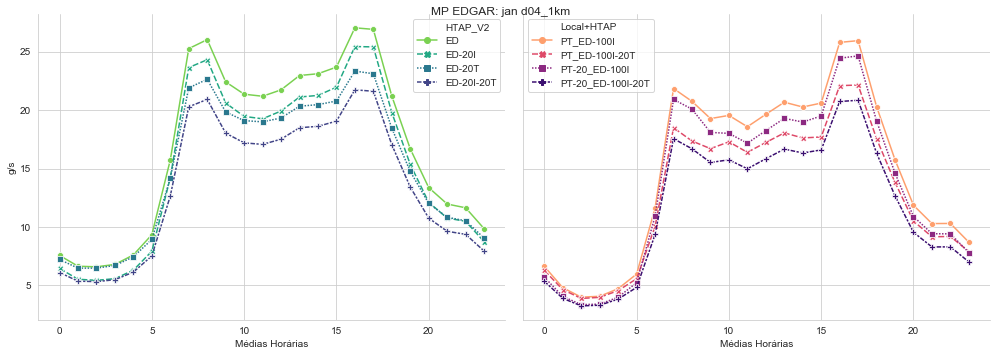

In [34]:
param = 'MP'
mesplt = mes[mes_index]
gradeplt = grade

ed={'TSTEP': mods[0].TSTEP}
for i in range(len(moded),len(moded)+len(modpt)):
    ed[modedname[i-4]] = mods[i].variables[param][:,0,:,:].sum(dim=['LAT', 'LON'])
ed_df = pd.DataFrame(ed)
ed_df.set_index('TSTEP', inplace=True)
ed_df=ed_df.stack()
ed_df = pd.DataFrame(ed_df.reset_index())
ed_df.columns = ['dt','HTAP_V2','emi']

pt={'TSTEP': mods[0].TSTEP}
for i in range(0,len(modpt)):
    pt[modpt[i]] = mods[i].variables[param][:,:,:].sum(dim=['LAT', 'LON'])
pt_df = pd.DataFrame(pt)
pt_df.set_index('TSTEP', inplace=True)
pt_df=pt_df.stack()
pt_df = pd.DataFrame(pt_df.reset_index())
pt_df.columns = ['dt','Local+HTAP','emi']

fig, axes = plt.subplots(ncols=2, nrows=1, figsize=(14,5), sharey=True) 
fig.suptitle(param+' EDGAR: '+mesplt+' '+gradeplt, fontsize=12)
sns.despine()
sns.set_style("whitegrid")
sns.lineplot(x=ed_df['dt'].dt.hour, y=ed_df['emi'], hue=ed_df['HTAP_V2'],
             palette='viridis_r',
             markers=True,
             style=ed_df['HTAP_V2'],
             ci=None,
             ax=axes[0])
sns.lineplot(x=pt_df['dt'].dt.hour, y=pt_df['emi'], hue=pt_df['Local+HTAP'], 
             palette='magma_r',
             markers=True,
             style=pt_df['Local+HTAP'],
             ci=None,
             ax=axes[1])
axes[0].set_xlabel('Médias Horárias')
axes[1].set_xlabel('Médias Horárias')
axes[0].set_ylabel(mods[i].variables[param].attrs['units'])
fig.tight_layout()


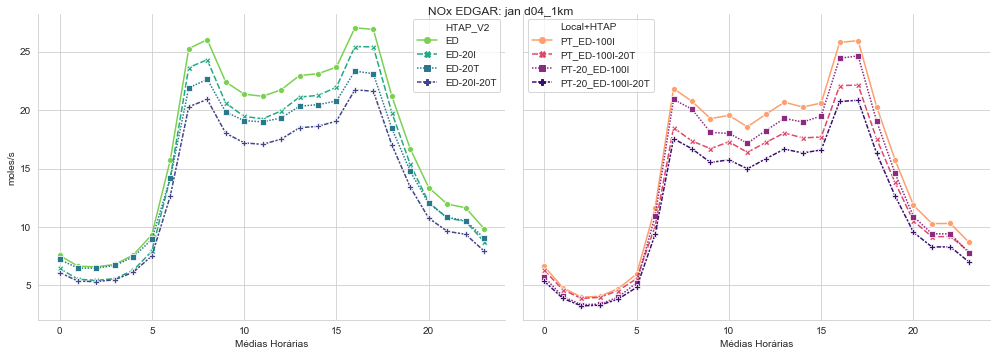

In [35]:
param = 'NOx'
mesplt = mes[mes_index]
gradeplt = grade

ed={'TSTEP': mods[0].TSTEP}
for i in range(len(moded),len(moded)+len(modpt)):
    ed[modedname[i-4]] = mods[i].variables[param][:,0,:,:].sum(dim=['LAT', 'LON'])
ed_df = pd.DataFrame(ed)
ed_df.set_index('TSTEP', inplace=True)
ed_df=ed_df.stack()
ed_df = pd.DataFrame(ed_df.reset_index())
ed_df.columns = ['dt','HTAP_V2','emi']

pt={'TSTEP': mods[0].TSTEP}
for i in range(0,len(modpt)):
    pt[modpt[i]] = mods[i].variables[param][:,:,:].sum(dim=['LAT', 'LON'])
pt_df = pd.DataFrame(pt)
pt_df.set_index('TSTEP', inplace=True)
pt_df=pt_df.stack()
pt_df = pd.DataFrame(pt_df.reset_index())
pt_df.columns = ['dt','Local+HTAP','emi']

fig, axes = plt.subplots(ncols=2, nrows=1, figsize=(14,5), sharey=True) 
fig.suptitle(param+' EDGAR: '+mesplt+' '+gradeplt, fontsize=12)
sns.despine()
sns.set_style("whitegrid")
sns.lineplot(x=ed_df['dt'].dt.hour, y=ed_df['emi'], hue=ed_df['HTAP_V2'],
             palette='viridis_r',
             markers=True,
             style=ed_df['HTAP_V2'],
             ci=None,
             ax=axes[0])
sns.lineplot(x=pt_df['dt'].dt.hour, y=pt_df['emi'], hue=pt_df['Local+HTAP'], 
             palette='magma_r',
             markers=True,
             style=pt_df['Local+HTAP'],
             ci=None,
             ax=axes[1])
axes[0].set_xlabel('Médias Horárias')
axes[1].set_xlabel('Médias Horárias')
axes[0].set_ylabel(mods[i].variables[param].attrs['units'])
fig.tight_layout()

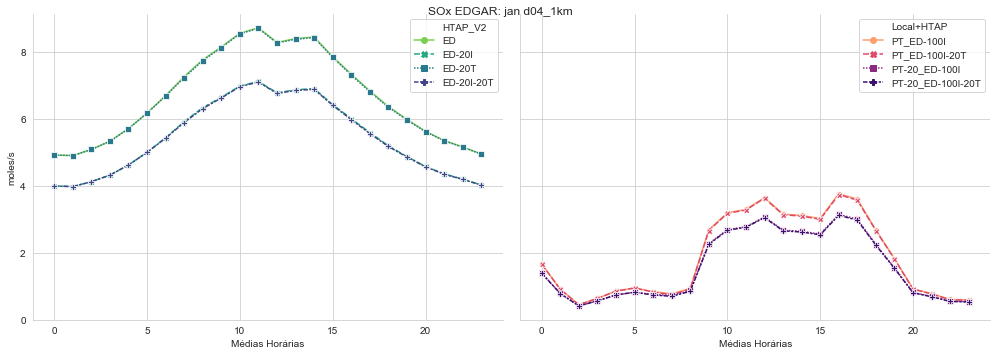

In [36]:
param = 'SOx'
mesplt = mes[mes_index]
gradeplt = grade

ed={'TSTEP': mods[0].TSTEP}
for i in range(len(moded),len(moded)+len(modpt)):
    ed[modedname[i-4]] = mods[i].variables[param][:,0,:,:].sum(dim=['LAT', 'LON'])
ed_df = pd.DataFrame(ed)
ed_df.set_index('TSTEP', inplace=True)
ed_df=ed_df.stack()
ed_df = pd.DataFrame(ed_df.reset_index())
ed_df.columns = ['dt','HTAP_V2','emi']

pt={'TSTEP': mods[0].TSTEP}
for i in range(0,len(modpt)):
    pt[modpt[i]] = mods[i].variables[param][:,:,:].sum(dim=['LAT', 'LON'])
pt_df = pd.DataFrame(pt)
pt_df.set_index('TSTEP', inplace=True)
pt_df=pt_df.stack()
pt_df = pd.DataFrame(pt_df.reset_index())
pt_df.columns = ['dt','Local+HTAP','emi']

fig, axes = plt.subplots(ncols=2, nrows=1, figsize=(14,5), sharey=True) 
fig.suptitle(param+' EDGAR: '+mesplt+' '+gradeplt, fontsize=12)
sns.despine()
sns.set_style("whitegrid")
sns.lineplot(x=ed_df['dt'].dt.hour, y=ed_df['emi'], hue=ed_df['HTAP_V2'],
             palette='viridis_r',
             markers=True,
             style=ed_df['HTAP_V2'],
             ci=None,
             ax=axes[0])
sns.lineplot(x=pt_df['dt'].dt.hour, y=pt_df['emi'], hue=pt_df['Local+HTAP'], 
             palette='magma_r',
             markers=True,
             style=pt_df['Local+HTAP'],
             ci=None,
             ax=axes[1])
axes[0].set_xlabel('Médias Horárias')
axes[1].set_xlabel('Médias Horárias')
axes[0].set_ylabel(mods[i].variables[param].attrs['units'])
fig.tight_layout()

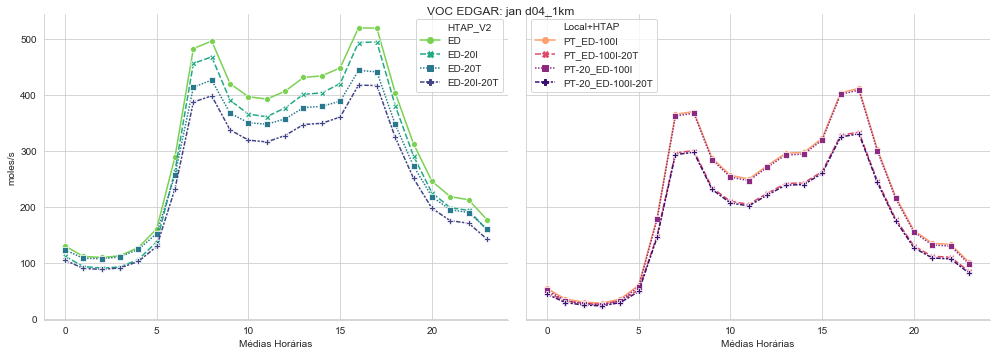

In [37]:
param = 'VOC'
mesplt = mes[mes_index]
gradeplt = grade

ed={'TSTEP': mods[0].TSTEP}
for i in range(len(moded),len(moded)+len(modpt)):
    ed[modedname[i-4]] = mods[i].variables[param][:,0,:,:].sum(dim=['LAT', 'LON'])
ed_df = pd.DataFrame(ed)
ed_df.set_index('TSTEP', inplace=True)
ed_df=ed_df.stack()
ed_df = pd.DataFrame(ed_df.reset_index())
ed_df.columns = ['dt','HTAP_V2','emi']

pt={'TSTEP': mods[0].TSTEP}
for i in range(0,len(modpt)):
    pt[modpt[i]] = mods[i].variables[param][:,:,:].sum(dim=['LAT', 'LON'])
pt_df = pd.DataFrame(pt)
pt_df.set_index('TSTEP', inplace=True)
pt_df=pt_df.stack()
pt_df = pd.DataFrame(pt_df.reset_index())
pt_df.columns = ['dt','Local+HTAP','emi']

fig, axes = plt.subplots(ncols=2, nrows=1, figsize=(14,5), sharey=True) 
fig.suptitle(param+' EDGAR: '+mesplt+' '+gradeplt, fontsize=12)
sns.despine()
sns.set_style("whitegrid")
sns.lineplot(x=ed_df['dt'].dt.hour, y=ed_df['emi'], hue=ed_df['HTAP_V2'],
             palette='viridis_r',
             markers=True,
             style=ed_df['HTAP_V2'],
             ci=None,
             ax=axes[0])
sns.lineplot(x=pt_df['dt'].dt.hour, y=pt_df['emi'], hue=pt_df['Local+HTAP'], 
             palette='magma_r',
             markers=True,
             style=pt_df['Local+HTAP'],
             ci=None,
             ax=axes[1])
axes[0].set_xlabel('Médias Horárias')
axes[1].set_xlabel('Médias Horárias')
axes[0].set_ylabel(mods[i].variables[param].attrs['units'])
fig.tight_layout()
